In [ ]:
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (24, 10)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 18

In [2]:
with open("analysis/society-staghunt.pickle", "rb") as f:
    data = pickle.load(f)

In [3]:
THRESHOLDS = [
    0.99,
    0.98,
    0.97,
    0.96,
    0.95,
    0.94,
    0.93,
    0.92,
    0.91,
    0.9,
    0.875,
    0.85,
    0.825,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
    0.2,
    0.1,
]

In [4]:
rows = []

with ProcessPoolExecutor(max_workers=6) as pool:
    futures = {
        pool.submit(get_graphs_at_thresholds, weights, THRESHOLDS): (population, lb)
        for (population, lb, t), weights_collection in data["train_weights"].items()
        for weights in weights_collection
    }

    for future in tqdm(as_completed(futures), total=len(futures)):
        population, lb = futures[future]
        Gs, edge_counts, clustering_coefficients = future.result()

        for threshold, edge_count, clustering_coefficient in zip(
            THRESHOLDS, edge_counts, clustering_coefficients
        ):
            rows.append([population, lb, threshold, edge_count, clustering_coefficient])

df = pd.DataFrame(
    rows,
    columns=[
        "population",
        "lookback",
        "threshold",
        "edge_count",
        "clustering_coefficient",
    ],
)

df

  0%|          | 0/360 [00:00<?, ?it/s]

,population,lookback,threshold,edge_count,clustering_coefficient
0,16,1,0.99,0,NaN
1,16,1,0.98,0,NaN
2,16,1,0.97,0,NaN
3,16,1,0.96,0,NaN
4,16,1,0.95,0,NaN
...,...,...,...,...,...
7555,512,3,0.50,121541,0.930611
7556,512,3,0.40,122800,0.939045
7557,512,3,0.30,123132,0.941456
7558,512,3,0.20,123243,0.942261


In [5]:
df.to_csv("analysis/staghunt_clustering_data.csv")

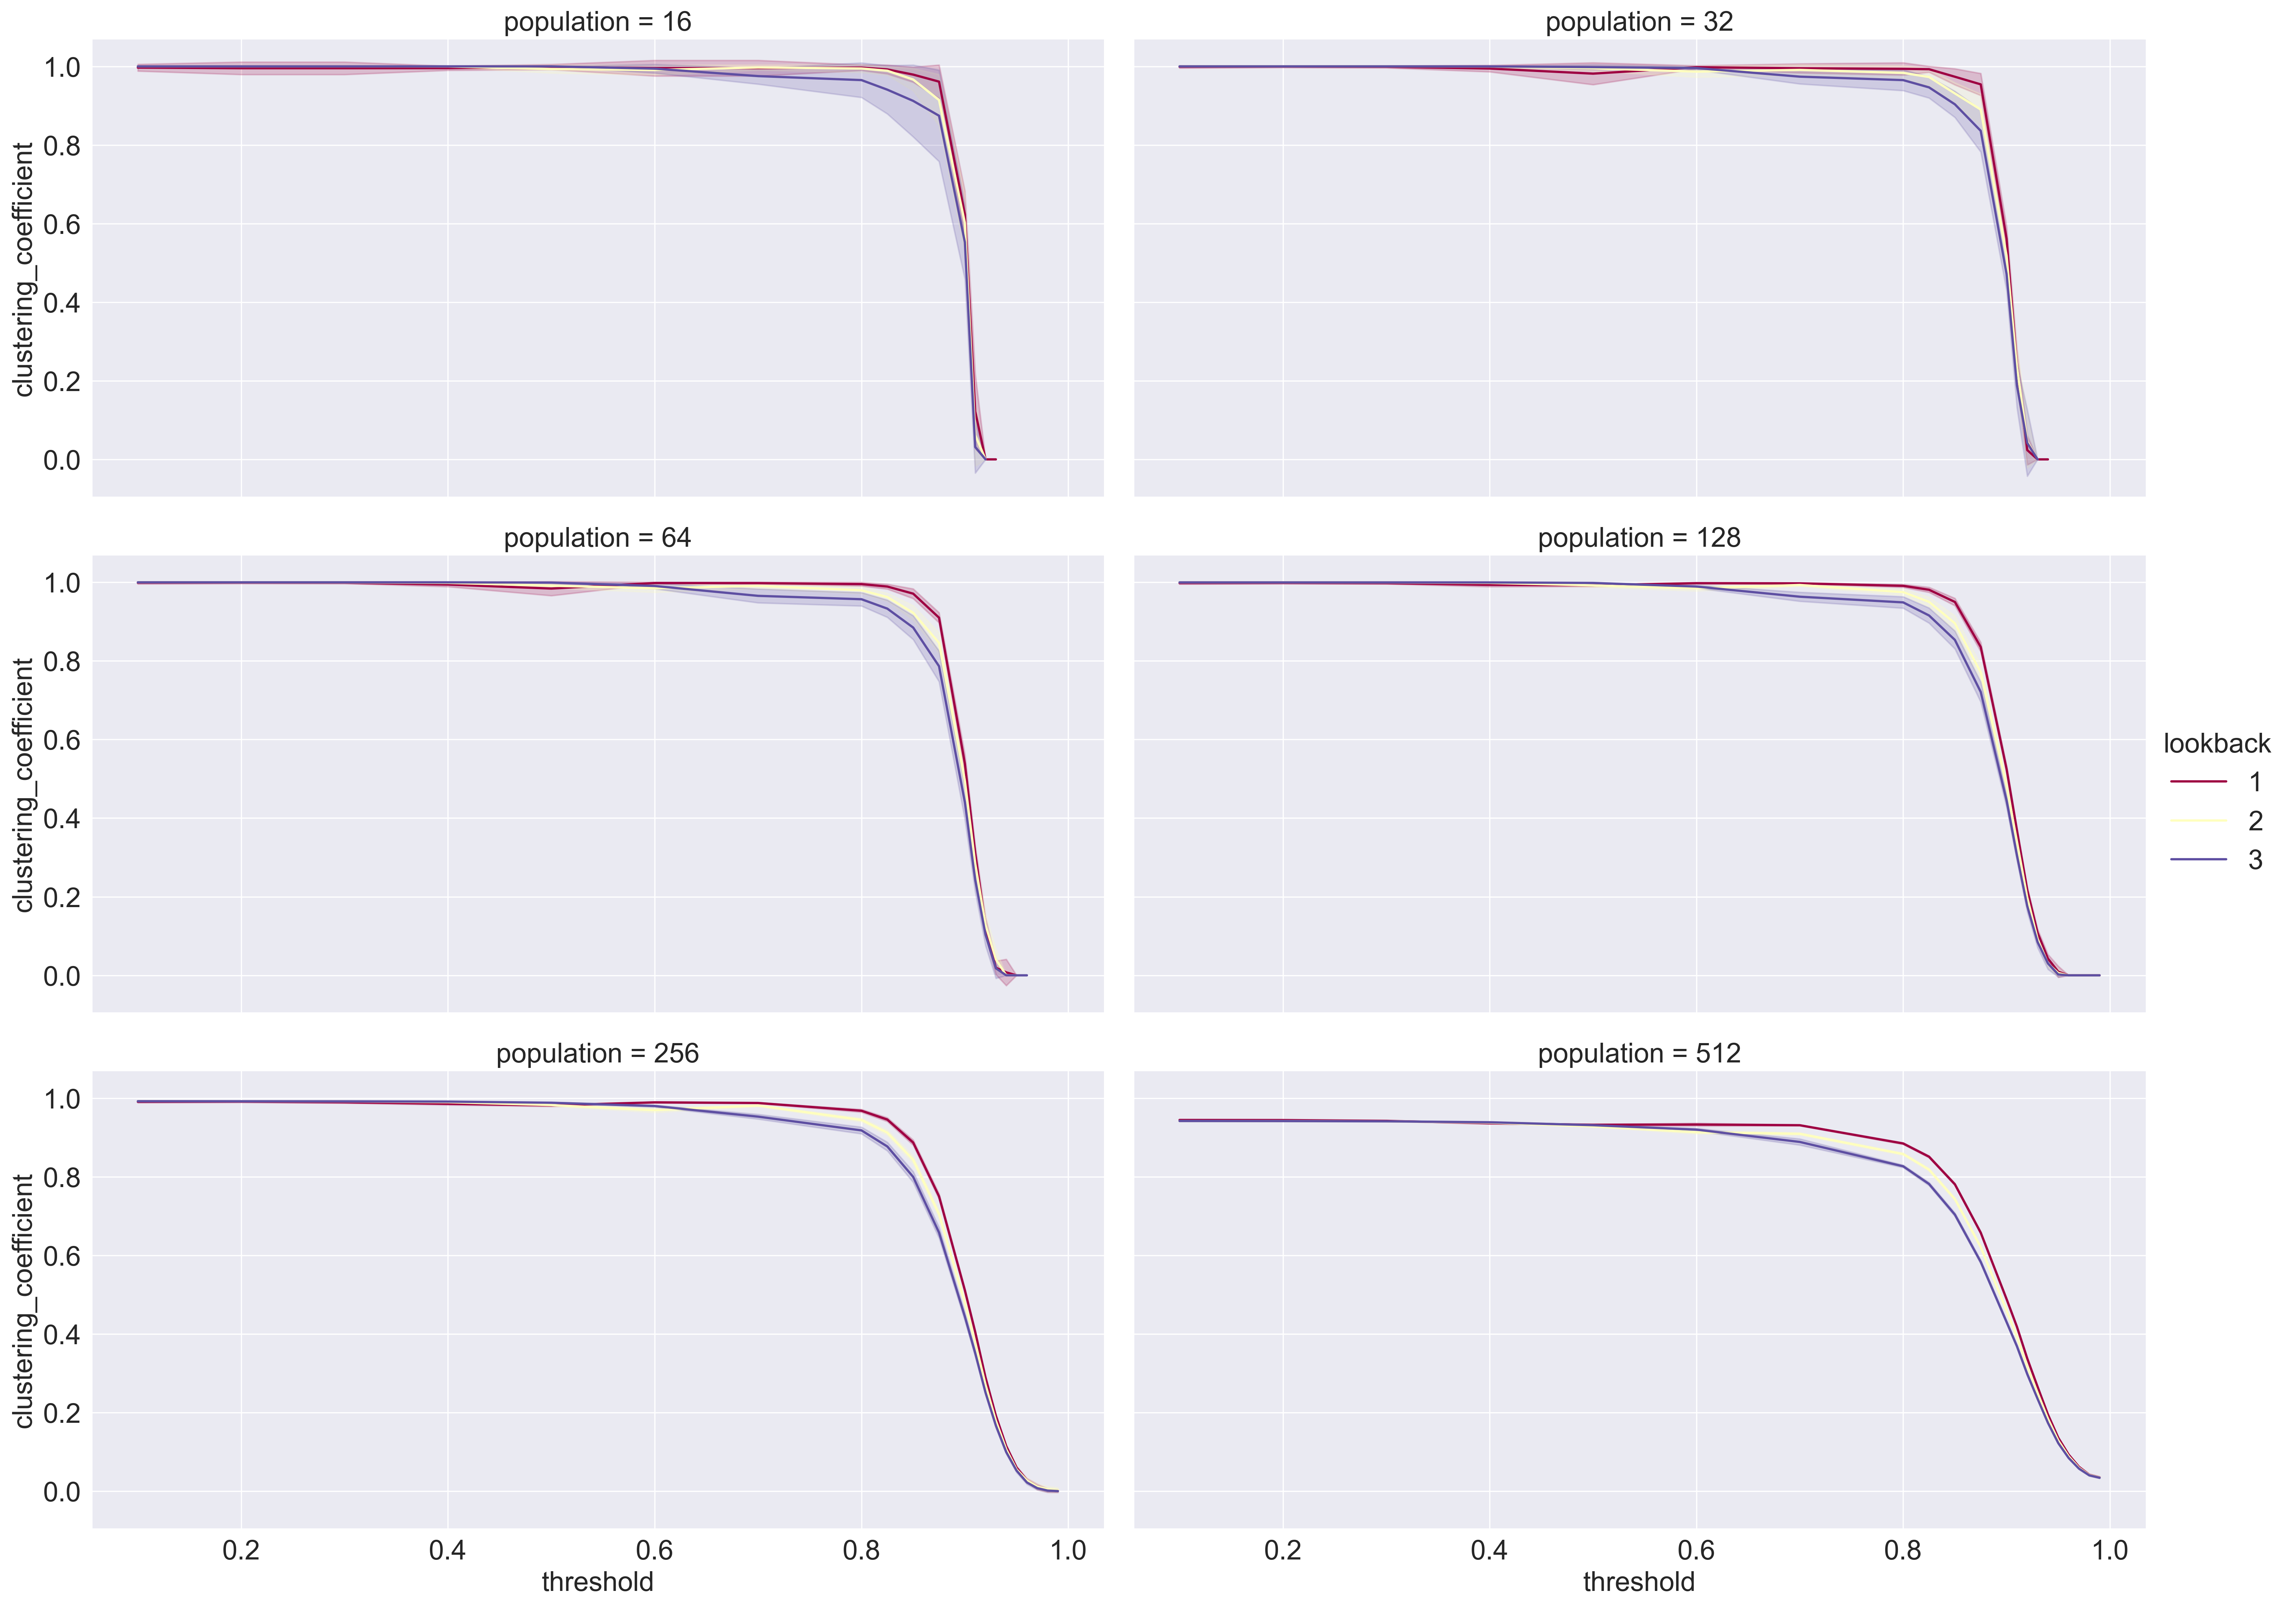

In [6]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="clustering_coefficient",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    errorbar="sd",
)

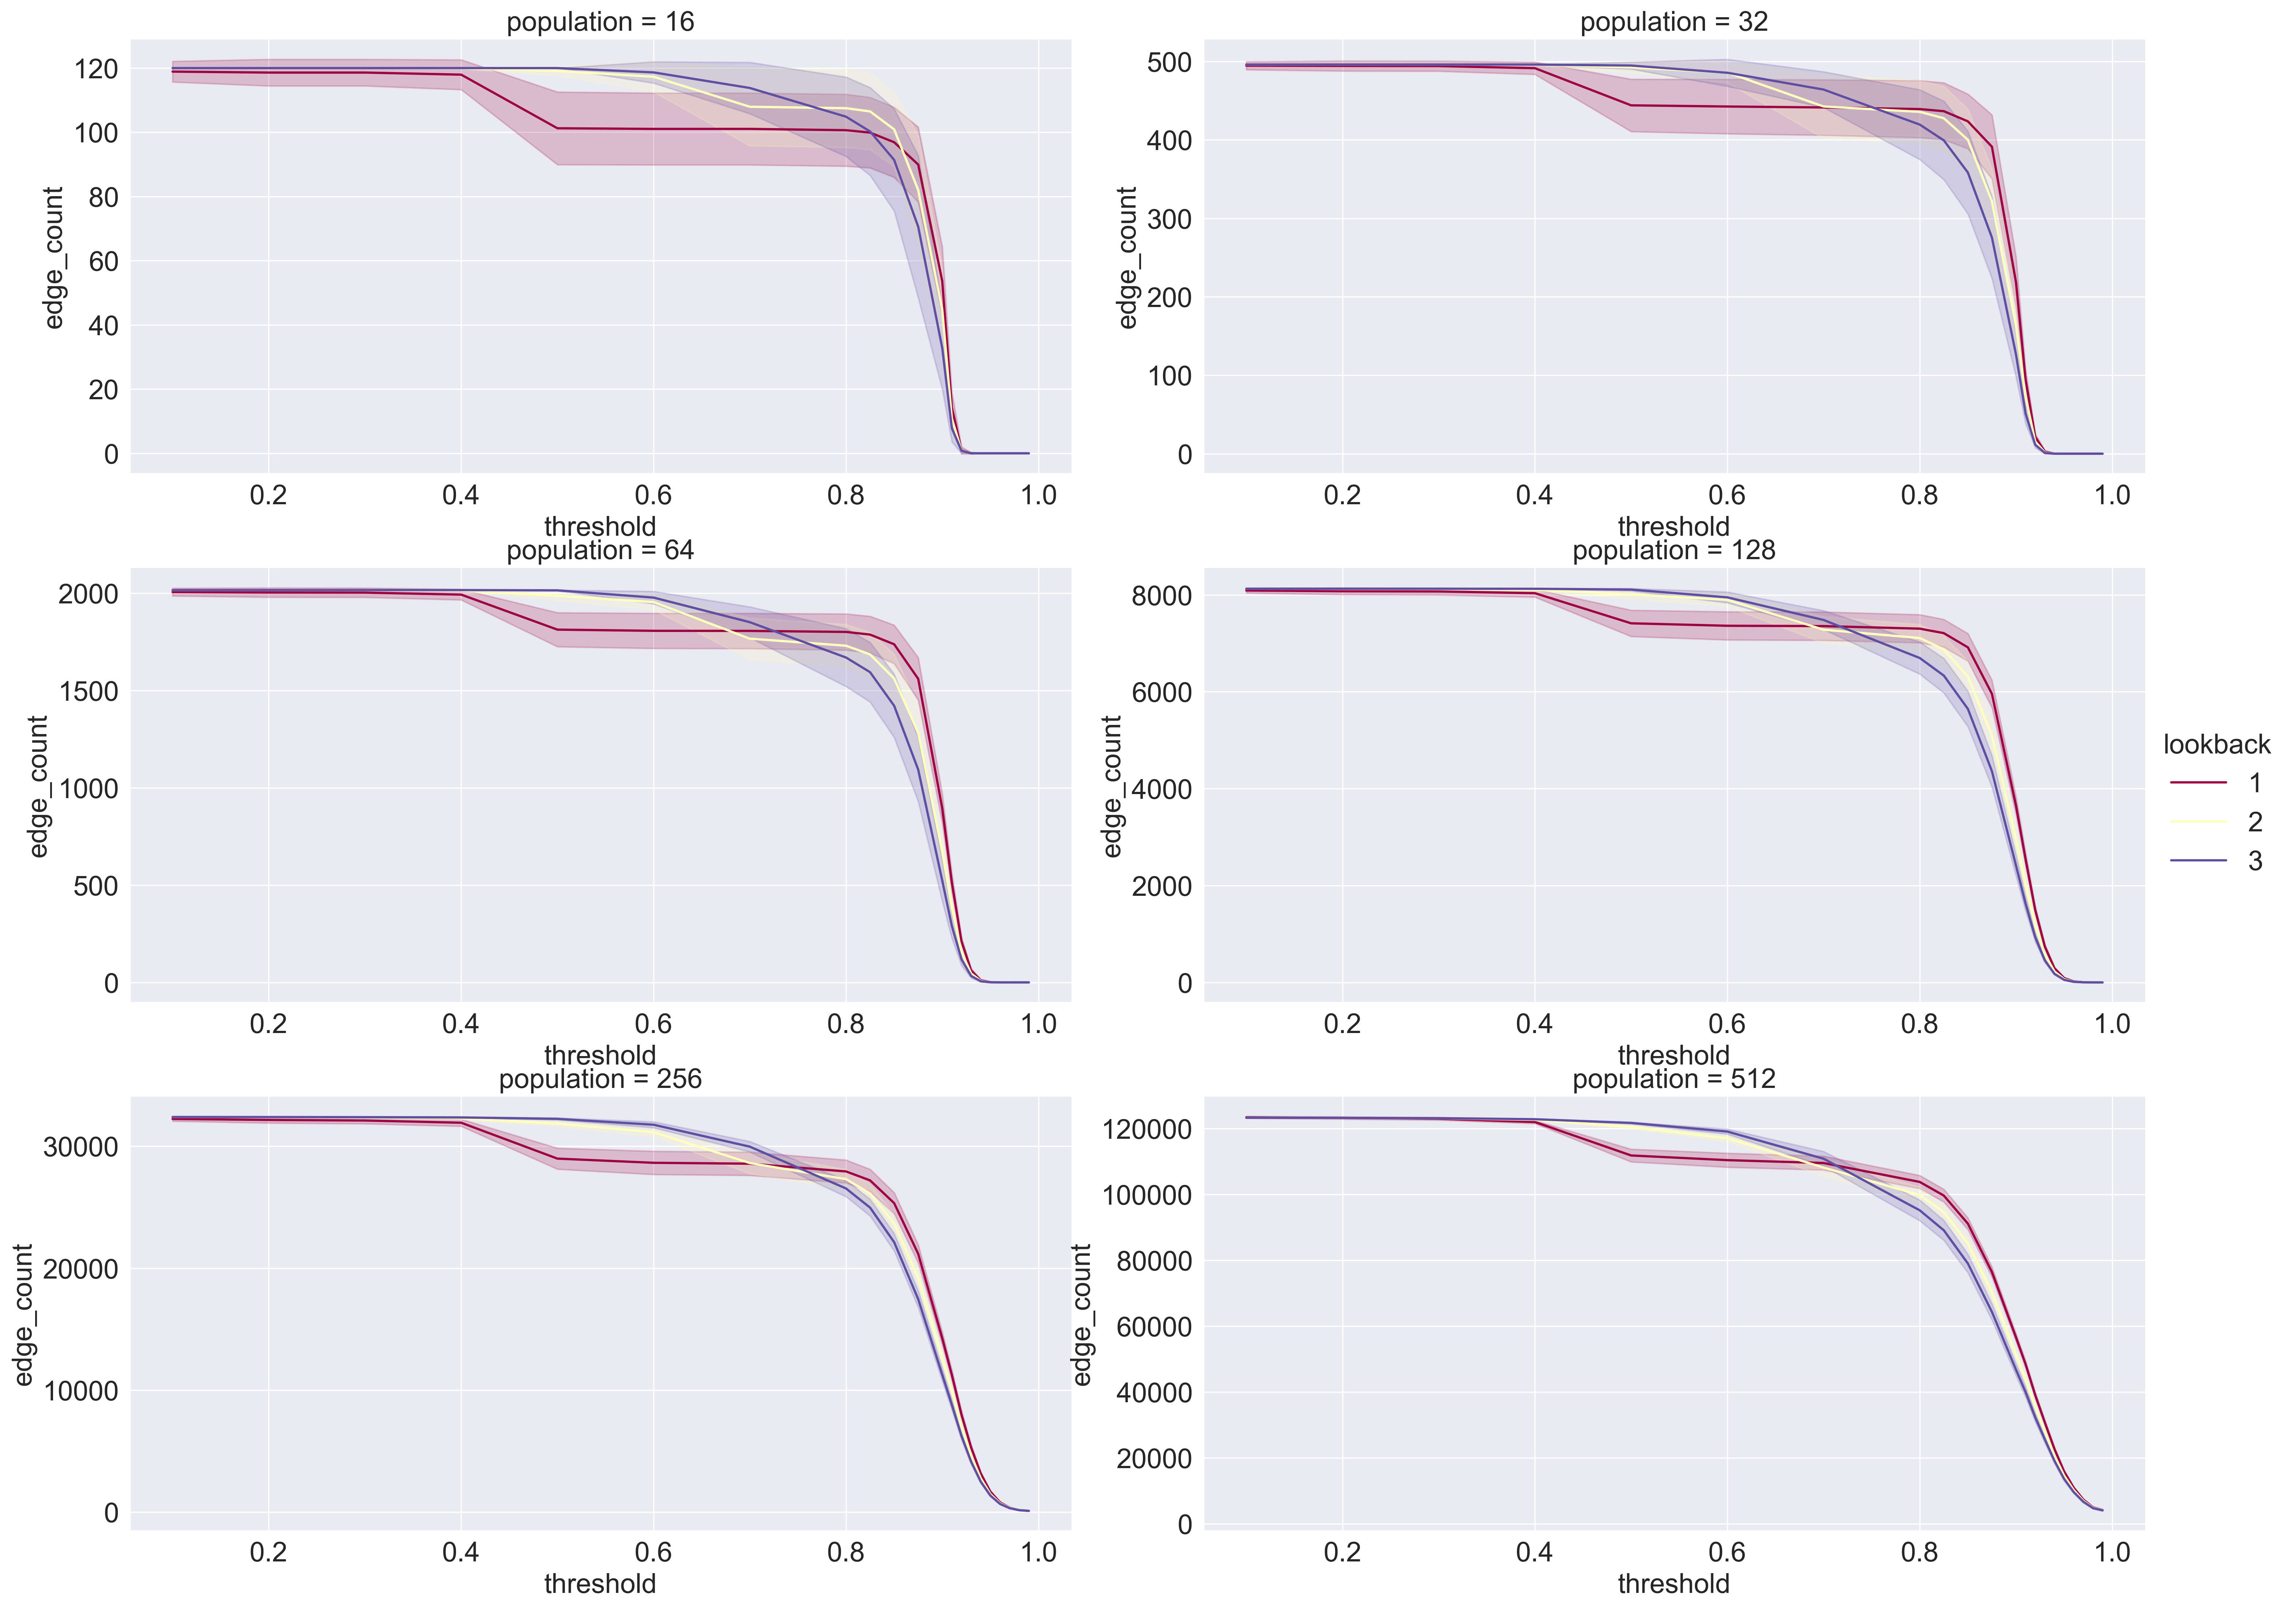

In [7]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="edge_count",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    facet_kws={"sharey": False, "sharex": False},
    errorbar="sd",
)

In [8]:
agg_df = (
    df[df["threshold"] == 0.9]
    .groupby(["population", "lookback", "threshold"])
    .agg(
        {
            "clustering_coefficient": ["mean", "std"],
        }
    )
    .round(3)
)

agg_df

clustering_coefficient       
                                                mean    std
population lookback threshold                              
16         1        0.9                        0.623  0.059
           2        0.9                        0.601  0.076
           3        0.9                        0.553  0.094
32         1        0.9                        0.561  0.031
           2        0.9                        0.518  0.049
           3        0.9                        0.472  0.043
64         1        0.9                        0.538  0.023
           2        0.9                        0.495  0.026
           3        0.9                        0.440  0.044
128        1        0.9                        0.525  0.008
           2        0.9                        0.482  0.016
           3        0.9                        0.445  0.017
256        1        0.9                        0.511  0.005
           2        0.9                        0.479  0.008
           3        0.9                        0.444  0.010
512        1        0.9                        0.489  0.003
           2        0.9                        0.460  0.003
           3        0.9                        0.431  0.004

In [9]:
for population, row in (
    agg_df.reset_index().pivot("population", columns="lookback").iterrows()
):
    print(
        population,
        *(
            f"${mean:.3f} \pm {std:.3f}$"
            for mean, std in zip(
                row["clustering_coefficient"]["mean"],
                row["clustering_coefficient"]["std"],
            )
        ),
        sep="\t&\t",
        end=" \\\\\n",
    )

C:\Users\jerem\AppData\Local\Temp/ipykernel_25416/3056726541.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  for population, row in agg_df.reset_index().pivot("population", columns="lookback").iterrows():


16	&	$0.623 \pm 0.059$	&	$0.601 \pm 0.076$	&	$0.553 \pm 0.094$ \\
32	&	$0.561 \pm 0.031$	&	$0.518 \pm 0.049$	&	$0.472 \pm 0.043$ \\
64	&	$0.538 \pm 0.023$	&	$0.495 \pm 0.026$	&	$0.440 \pm 0.044$ \\
128	&	$0.525 \pm 0.008$	&	$0.482 \pm 0.016$	&	$0.445 \pm 0.017$ \\
256	&	$0.511 \pm 0.005$	&	$0.479 \pm 0.008$	&	$0.444 \pm 0.010$ \\
512	&	$0.489 \pm 0.003$	&	$0.460 \pm 0.003$	&	$0.431 \pm 0.004$ \\
